## Importamos las bibliotecas a usar

In [1]:
import kagglehub
from PIL import Image
from itertools import islice
import glob
import matplotlib.pyplot as plt
import random

<br>
<br>

## Descargamos Dataset

In [2]:
path = kagglehub.dataset_download("tapakah68/selfies-id-images-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/israncho/.cache/kagglehub/datasets/tapakah68/selfies-id-images-dataset/versions/5


<br>
<br>

#### Creamos Lista con las rutas a todas las imagenes

En este caso tenemos las imagenes de $29$ peronas, y $13$ selfies
de cada una de estas, por lo que tendremos $377$ imagenes en total.

In [3]:
# Solo usamos las selfies
IMAGE_FILES = glob.glob(path + "/**/Selfie*.jpg", recursive=True)
print('Numer  de imagenes:', len(IMAGE_FILES))

Numer  de imagenes: 377


<br>
<br>

La mayoria de los las imagenes tienen buena resolucion $2300 \times 3088$ pixeles, 
aunque no todos tiene las mismas dimensiones, y ademas son demasiado grandes para los fines
de este proyecto, razones por las cuales les realizaremos una reduccion de escala.

**Si se requiere ver el tamaño real de la imagen se debe descomentar la linea**

```python
#plt.figure(figsize=(width / DPI, height / DPI))
````

ruta del archivo:
 /home/israncho/.cache/kagglehub/datasets/tapakah68/selfies-id-images-dataset/versions/5/Selfies ID Images dataset/11_sets_Hispanics/0001cc1e1e--61af86f374501f072edf6d2c_age_22_name_Juliana/Selfie_11.jpg
Dimensiones: 2320 , 3088


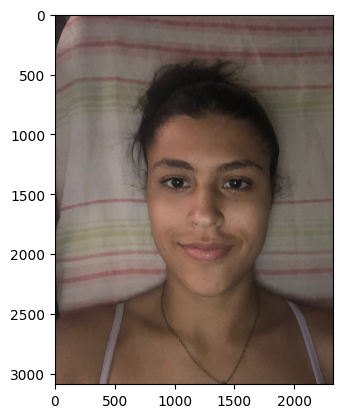

In [4]:
# Abrir la primera imagen
image = Image.open(IMAGE_FILES[0])
print('ruta del archivo:\n', IMAGE_FILES[0])
DPI = 96 # pixeles por pulgada
width, height = image.size
#plt.figure(figsize=(width / DPI, height / DPI))  # PARA VER EL TAMA~NO REAL hay que descomentar esta linea <--------------------------------------------
plt.imshow(image)
print('Dimensiones:', width, ',', height)

### Reduccion de escala

Si se descomento la linea mencionada se podra ver que en efecto es demasiado grande, por lo que trabajaremos las imagenes con una 
escala reducida, usaremos $\%8$ del tamaño original. 

nuevas dimensiones: 162 , 216


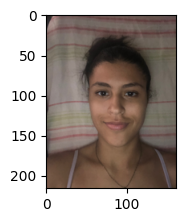

In [5]:
downscaled_width, downscaled_height = int(width * .07) , int(height * .07)
print('nuevas dimensiones:', downscaled_width, ',', downscaled_height)
downscaled_img = image.resize((downscaled_width, downscaled_height))
plt.figure(figsize=(downscaled_width / DPI, downscaled_height / DPI))
plt.imshow(downscaled_img)

In [6]:
WIDTH, HEIGHT = downscaled_width, downscaled_height

<br>
<br>

Para facilitar la creacion del dataset con supervision primiero organizaremos
la lista con las rutas de las imagenes de una forma distinta.

Podemos notar que si dividimos las cadenas con respecto al caracter `/`
la penultima cadena siempre son los datos de la persona y nos puede
servir como identificador.

In [7]:
IMAGE_FILES[0].split('/')[-2]

'0001cc1e1e--61af86f374501f072edf6d2c_age_22_name_Juliana'

<br>
<br>

**Creamos un diccionario** donde las llaves son el id de la persona
y el valor es el indice de la imagen (en realidad es la ruta absoluta
en el sistema) dentro de

```python
IMAGE_FILES
```


In [8]:
def organized_dataset(image_files: list[str]) -> dict:
    dataset = {}
    for i, image_full_path in enumerate(image_files):
        person_id = image_full_path.split('/')[-2]
        if person_id not in dataset:
            dataset[person_id] = []
        dataset[person_id].append(i)
    return dataset

In [9]:
DATASET = organized_dataset(IMAGE_FILES)
print('Personas:', len(DATASET))

Personas: 29


In [10]:
def supervised_dataset(dataset: dict) -> tuple[list, list]:
    supervised_ds = []
    all_ids = set(dataset.keys())
    
    for person_id in dataset.keys():
        # computing matching_img, same person
        for j, img_j in enumerate(dataset[person_id]):
            for img_k in islice(dataset[person_id], j + 1, None):
                supervised_ds.append((img_j, img_k, 1))


        # computing mismatching_img, different person
        all_ids.remove(person_id) # temporary remove to compare with others
        for img_i in dataset[person_id]:
            for other_person_id in all_ids:
                mismatched_img = list(map(lambda x: (img_i, x, 0), dataset[other_person_id]))
                supervised_ds.extend(mismatched_img)
        all_ids.add(person_id)

    return supervised_ds

In [11]:
SUPERVISED_DATASET = supervised_dataset(DATASET)
print(len(SUPERVISED_DATASET))

139490


In [12]:
CLASS0 = list(filter(lambda x: x[2] == 0 , SUPERVISED_DATASET))
CLASS1 = list(filter(lambda x: x[2] == 1 , SUPERVISED_DATASET))

In [13]:
def show_imgs_side_to_side(path_img1: str, path_img2: str, width, height, dpi):
    img1 = Image.open(path_img1)
    img2 = Image.open(path_img2)
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    axes[0].imshow(img1)
    axes[0].axis('off')  # Desactivar los ejes
    axes[0].set_title("Imagen 1")
    
    axes[1].imshow(img2)
    axes[1].axis('off')  # Desactivar los ejes
    axes[1].set_title("Imagen 2")
    
    plt.tight_layout()
    plt.show()


<br>
<br>

### Ejemplo de dato de entrenamiento aleatorio de la clase 0 sin reducir

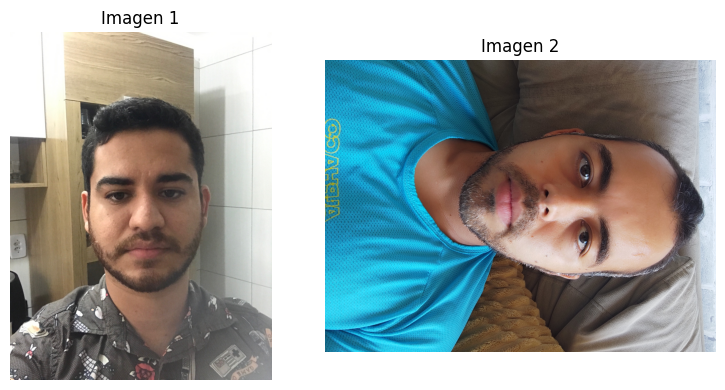

In [14]:
fst_img_i, snd_img_i, _ = random.choice(CLASS0)
show_imgs_side_to_side(IMAGE_FILES[fst_img_i], IMAGE_FILES[snd_img_i], WIDTH, HEIGHT, DPI)

<br>
<br>

### Ejemplo de dato de entrenamiento aleatorio de la clase 1 sin reducir

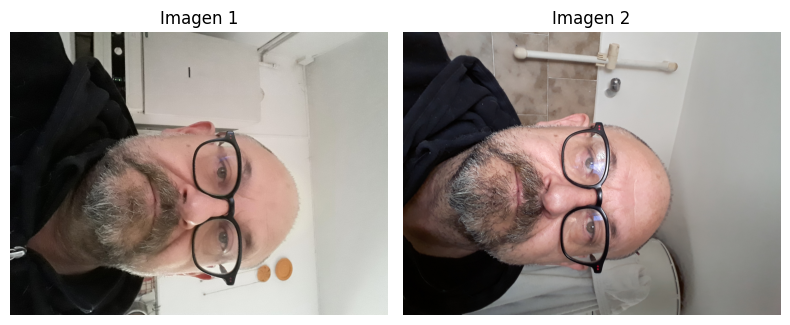

In [15]:
fst_img_i, snd_img_i, _ = random.choice(CLASS1)
show_imgs_side_to_side(IMAGE_FILES[fst_img_i], IMAGE_FILES[snd_img_i], WIDTH, HEIGHT, DPI)